In [1]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):

    def __init__(self, texts, targets, tokenizer, max_len=512):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        target = self.targets[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F
from IPython.display import clear_output
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [75]:
df = pd.read_csv('/kaggle/input/data-for-bert/data_to_save.csv').drop('Unnamed: 0', axis=1).reset_index(drop=True)
le = LabelEncoder()
le.fit(df['category'])
df['category_int'] = le.transform(df['category'])

In [78]:
class BertClassifier:

    def __init__(self, model_path, tokenizer_path, n_classes=2, epochs=1, model_save_path='/content/bert.pt'):
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model_save_path=model_save_path
        self.max_len = 512
        self.epochs = epochs
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)
    
    def preparation(self, X_train, y_train, X_valid, y_valid):
        # create datasets
        self.train_set = CustomDataset(X_train, y_train, self.tokenizer)
        self.valid_set = CustomDataset(X_valid, y_valid, self.tokenizer)

        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=2, shuffle=True)
        self.valid_loader = DataLoader(self.valid_set, batch_size=2, shuffle=True)

        # helpers initialization
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=0,
                num_training_steps=len(self.train_loader) * self.epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)
            
    def fit(self):
        self.model = self.model.train()
        losses = []
        all_logits = []
        all_targets = []
        for data in tqdm(self.train_loader, desc='Братья тренируются'):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            loss = self.loss_fn(outputs.logits, targets)
            
            losses.append(loss.item())
        
            all_logits += [outputs.logits.detach().cpu()]
            all_targets += [targets.cpu()]
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()
        
        all_logits = torch.cat(all_logits, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        preds = F.softmax(all_logits, dim=1).numpy()
        train_roc_auc = roc_auc_score(all_targets,
                                      preds,
                                      multi_class='ovr')
        train_loss = np.mean(losses)
        return train_roc_auc, train_loss
    
    def eval(self):
        self.model = self.model.eval()
        losses = []
        all_logits = []
        all_targets = []
        with torch.no_grad():
            for data in tqdm(self.valid_loader, desc='Братья работают над валидацией'):
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                targets = data["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )

                loss = self.loss_fn(outputs.logits, targets)
                all_logits += [outputs.logits.detach().cpu()]
                all_targets += [targets.cpu()]
            
                losses.append(loss.item())
        
        all_logits = torch.cat(all_logits, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        preds = F.softmax(all_logits, dim=1).numpy()
        val_roc_auc = roc_auc_score(all_targets,
                                    preds,
                                    multi_class='ovr')
        val_loss = np.mean(losses)
        return val_roc_auc, val_loss
    
    def train(self):
        bestval_roc_auc = 0
        history_train_loss = []
        history_train_roc_auc = []
        history_val_loss = []
        history_val_roc_auc = []
        for epoch in range(self.epochs):
            
            print(f'Epoch {epoch + 1}/{self.epochs}')
            train_roc_auc, train_loss = self.fit()
           

            val_roc_auc, val_loss = self.eval()
            clear_output(wait=True)
            print(f'Train loss {train_loss} ROC-AUC {train_roc_auc}')
            print(f'Val loss {val_loss} ROC-AUC {val_roc_auc}')
            print('-' * 10)
            
            history_train_loss += [train_loss]
            history_train_roc_auc += [train_roc_auc]
            history_val_loss += [val_loss]
            history_val_roc_auc += [val_roc_auc]
            
            
            
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 2, 1)
            plt.xlabel("Iteration")
            plt.ylabel("Train Loss")
            plt.grid()
            plt.plot(history_train_loss)
            
            plt.subplot(1, 2, 2)
            plt.xlabel("Iteration")
            plt.ylabel("Val ROC-AUC")
            plt.plot(history_val_roc_auc, color="purple")
            plt.grid()
            
            plt.show()

            if val_roc_auc > bestval_roc_auc:
                torch.save(self.model, self.model_save_path)
                bestval_roc_auc = val_roc_auc

        self.model = torch.load(self.model_save_path)
    
    def predict(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return 

In [79]:
classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny',
        tokenizer_path='cointegrated/rubert-tiny',
        n_classes=4,
        epochs=10,
        model_save_path='bert.pth'
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
train_in, test_in, train_target, test_target = train_test_split(df['sentence'], df['category_int'], test_size=3000,
                                                          random_state=42)

In [82]:
classifier.preparation(
        X_train=list(train_in),
        y_train=list(train_target),
        X_valid=list(test_in),
        y_valid=list(test_target)
    )

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Train loss 0.7719982168767947 ROC-AUC 0.9365606689859248
Val loss 1.691555297867395 ROC-AUC 0.8186554272130917
----------


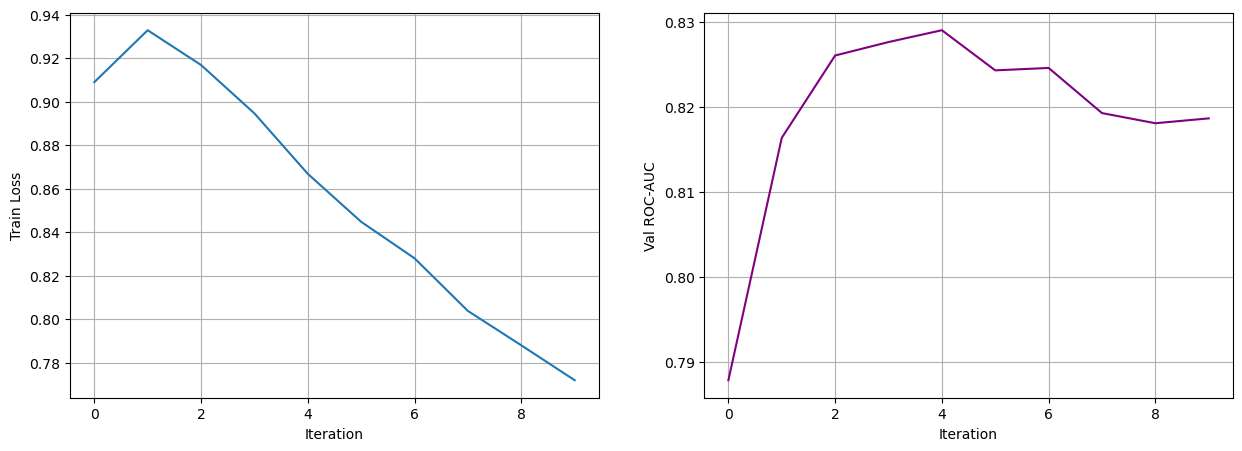

In [83]:
classifier.train()